In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import pandas as pd
import os
# Import libraries necessary for this analysis
from itertools import  count

#import renders as rs
from IPython.display import display # Allows the use of display() for DataFrames

from library import *
#from Models import *


import seaborn as sns
sns.set(style="ticks")

from __future__ import division

import matplotlib.pyplot as plt
from numpy import linspace, loadtxt, ones, convolve
import numpy as np
import pandas as pd

from random import randint
from matplotlib import style
style.use('fivethirtyeight')

%matplotlib inline
%matplotlib notebook
izip = zip
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN, SpectralClustering, KMeans

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
host = 'prod-pentaho.cxfaihg8elfv.eu-west-1.rds.amazonaws.com'
host = '10.0.5.209'
db = 'billin_prod'
user = 'billin'
password = 'ThisIsTheRiverOfTheNight'

db = DB(host=host, db=db, user=user, password=password)

df = db.gettable('users')
df.set_index('id',inplace=True)
columns = df.describe().columns.tolist()

In [ ]:
dforig = df.copy()

In [4]:
df.shape

(28986, 26)

In [5]:
columns

['activated',
 'avatar',
 'created_at',
 'deleted_at',
 'email',
 'email_invoice_received',
 'email_business_role_change',
 'email_business_user_added',
 'email_chat_new_messages',
 'email_contact_new_request',
 'email_invoice_due_dates',
 'email_invoice_status_changed',
 'lastname',
 'last_seen',
 'locked',
 'name',
 'password',
 'referrer',
 'signup_from',
 'updated_at',
 'vip',
 'expo_token',
 'sourced',
 'signup_by',
 'services_communication_permission',
 'third_party_sharing_permission']

In [6]:
temp = df.drop(labels=['password', 'email', 'created_at', 'updated_at', 'locked', 'vip', 'third_party_sharing_permission', 'name', 'lastname'], axis=1)
temp['last_seen'] = temp.last_seen.map(lambda c: int(c.timestamp()) if c is not pd.NaT else 0 )
temp['deleted_at'] = temp.deleted_at.map(lambda c: int(c.timestamp()) if c is not pd.NaT else 0 )

yesterday = int(pd.datetime.today().timestamp()) - 86400
lastweek = int(pd.datetime.today().timestamp()) - (86400 * 7)
lastmonth = int(pd.datetime.today().timestamp()) - (86400 * 30)
threemonths = int(pd.datetime.today().timestamp()) - (86400 * 90)
sixmonths = int(pd.datetime.today().timestamp()) - (86400 * 180)

temp['last_seen_yesterday'] = temp.last_seen.map(lambda c: 1 if (c - yesterday) >= 0 else 0)
temp['last_seen_lastweek'] = temp.last_seen.map(lambda c: 1 if (c - lastweek) >= 0 else 0)
temp['last_seen_lastmonth'] = temp.last_seen.map(lambda c: 1 if (c - lastmonth) >= 0 else 0)
temp['last_seen_threemonths'] = temp.last_seen.map(lambda c: 1 if (c - threemonths) >= 0 else 0)
temp['last_seen_sixmonths'] = temp.last_seen.map(lambda c: 1 if (c - sixmonths) >= 0 else 0)

temp['deleted_at_yesterday'] = temp.deleted_at.map(lambda c: 1 if (c - yesterday) >= 0 else 0)
temp['deleted_at_lastweek'] = temp.deleted_at.map(lambda c: 1 if (c - lastweek) >= 0 else 0)
temp['deleted_at_lastmonth'] = temp.deleted_at.map(lambda c: 1 if (c - lastmonth) >= 0 else 0)
temp['deleted_at_threemonths'] = temp.deleted_at.map(lambda c: 1 if (c - threemonths) >= 0 else 0)
temp['deleted_at_sixmonths'] = temp.deleted_at.map(lambda c: 1 if (c - sixmonths) >= 0 else 0)
temp.drop(columns=['last_seen', 'deleted_at'], inplace=True)

temp.activated = temp.activated.astype(int)
temp.email_invoice_received = temp.email_invoice_received.astype(int)
temp.email_business_role_change = temp.email_business_role_change.astype(int)
temp.email_business_user_added = temp.email_business_user_added.astype(int)
temp.email_chat_new_messages = temp.email_chat_new_messages.astype(int)
temp.email_contact_new_request = temp.email_contact_new_request.astype(int)
temp.email_invoice_due_dates = temp.email_invoice_due_dates.astype(int)
temp.email_invoice_status_changed = temp.email_invoice_status_changed.astype(int)

temp.services_communication_permission = temp.services_communication_permission.astype(int)

temp.avatar = temp.avatar.map(lambda a: 0 if a == 'default.png' else a)
temp.avatar = temp.avatar.map(lambda a: 1 if a is None else a)
temp.avatar = temp.avatar.map(lambda a: 2 if a != 0 and a != 1 else a)

temp = pd.concat([temp, pd.get_dummies(temp.signup_from, prefix='signup_from_')], axis=1)
temp.drop(columns='signup_from', inplace=True)

temp = pd.concat([temp, pd.get_dummies(temp.sourced, prefix='sourced_')], axis=1)
temp.drop(columns='sourced', inplace=True)

signup_by = pd.get_dummies(temp.signup_by, dummy_na=True)
signup_by.columns = ['signup_by_A', 'signup_by_B', 'signup_by_NaN']
temp = pd.concat([temp, signup_by], axis=1)
temp.drop(columns='signup_by', inplace=True)

expo_token = pd.get_dummies(temp.expo_token, dummy_na=True)
expo_token.columns = ['expo_token_A', 'expo_token_B', 'expo_token_C','expo_token_D','expo_token_E','expo_token_NaN']
temp = pd.concat([temp, expo_token], axis=1)
temp.drop(columns='expo_token', inplace=True)

temp.referrer = temp.referrer.map(lambda r: 0 if r is None else 1)

In [7]:
display(temp.head())

,activated,avatar,email_invoice_received,email_business_role_change,email_business_user_added,email_chat_new_messages,email_contact_new_request,email_invoice_due_dates,email_invoice_status_changed,referrer,...,sourced__web,signup_by_A,signup_by_B,signup_by_NaN,expo_token_A,expo_token_B,expo_token_C,expo_token_D,expo_token_E,expo_token_NaN
id,,,,,,,,,,,,,,,,,,,,,
9d2ddfd1-d138-4f49-add9-35e8ad03ae36,0,0,1,1,1,1,1,1,1,0,...,1,0,0,1,0,0,0,0,0,1
a2ecc818-8e4f-44f9-bccb-4fd11dde6139,1,1,1,1,1,1,1,1,1,1,...,1,0,0,1,0,0,0,0,0,1
44b22e25-3263-4559-801a-faa7c2d646c5,1,0,1,1,1,1,1,1,1,0,...,1,0,0,1,0,0,0,0,0,1
cb2b3ef2-f7d5-4b7e-969e-89aab7bfc8ea,1,2,1,1,1,1,1,1,1,0,...,1,0,0,1,0,0,0,0,0,1
e71ac857-eaf2-42a7-8f12-47af4ea911f5,1,0,1,1,1,1,1,1,1,0,...,1,0,0,1,0,0,0,0,0,1


In [8]:
temp.describe()

,activated,avatar,email_invoice_received,email_business_role_change,email_business_user_added,email_chat_new_messages,email_contact_new_request,email_invoice_due_dates,email_invoice_status_changed,referrer,...,sourced__web,signup_by_A,signup_by_B,signup_by_NaN,expo_token_A,expo_token_B,expo_token_C,expo_token_D,expo_token_E,expo_token_NaN
count,28986.000000,28986.000000,28986.000000,28986.000000,28986.000000,28986.000000,28986.000000,28986.000000,28986.000000,28986.000000,...,28986.000000,28986.000000,28986.000000,28986.000000,28986.000000,28986.000000,28986.000000,28986.000000,28986.000000,28986.000000
mean,0.621300,0.272683,0.993549,0.991824,0.991893,0.992928,0.992824,0.993169,0.991306,0.142172,...,0.975954,0.001380,0.064859,0.933761,0.000034,0.000034,0.000034,0.000034,0.000034,0.999828
std,0.485072,0.606693,0.080062,0.090054,0.089677,0.083801,0.084408,0.082368,0.092836,0.349233,...,0.153195,0.037123,0.246281,0.248703,0.005874,0.005874,0.005874,0.005874,0.005874,0.013133
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [9]:
temp.columns

Index(['activated', 'avatar', 'email_invoice_received',
       'email_business_role_change', 'email_business_user_added',
       'email_chat_new_messages', 'email_contact_new_request',
       'email_invoice_due_dates', 'email_invoice_status_changed', 'referrer',
       'services_communication_permission', 'last_seen_yesterday',
       'last_seen_lastweek', 'last_seen_lastmonth', 'last_seen_threemonths',
       'last_seen_sixmonths', 'deleted_at_yesterday', 'deleted_at_lastweek',
       'deleted_at_lastmonth', 'deleted_at_threemonths',
       'deleted_at_sixmonths', 'signup_from__add_user', 'signup_from__app',
       'signup_from__billinV2', 'signup_from__contact_request',
       'signup_from__direct_signup', 'signup_from__invoice',
       'signup_from__singup', 'sourced__app', 'sourced__web', 'signup_by_A',
       'signup_by_B', 'signup_by_NaN', 'expo_token_A', 'expo_token_B',
       'expo_token_C', 'expo_token_D', 'expo_token_E', 'expo_token_NaN'],
      dtype='object')

In [10]:
indexes = temp.index

X2,pca  = rulePCA(temp, n=2)
#dforig = df[columns].copy()
df2pca = pd.DataFrame(X2,columns=['d1','d2'], index=temp.index)

X3,pca  = rulePCA(temp, n=3)
#dforig = df[columns].copy()
df3pca = pd.DataFrame(X3,columns=['d1','d2', 'd3'], index=temp.index)

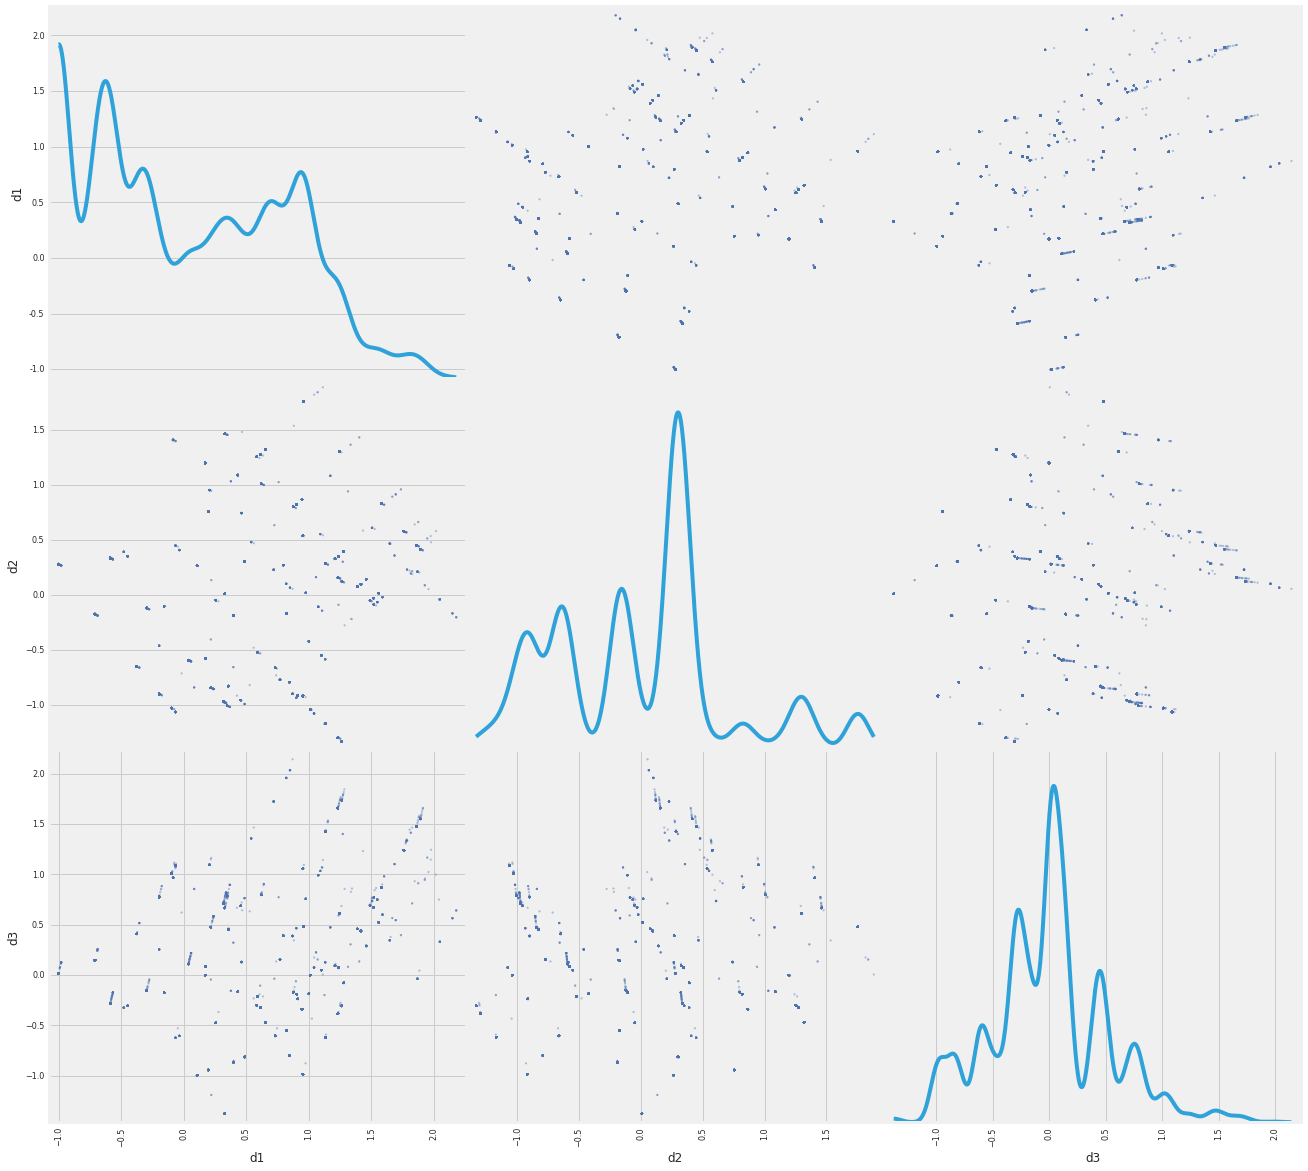

In [11]:
ScatterMatrix(df3pca)

In [12]:
rng = np.random.RandomState(42)

# Generate train data
X_train = df2pca[['d1', 'd2']].as_matrix()
X_test = df2pca.sample(n=1000).as_matrix()
X_outliers = df2pca.sample(n=100).as_matrix()

# fit the model
clf = IsolationForest(n_estimators=50, max_samples=50, random_state=rng, n_jobs=48, contamination=0.07)
clf.fit(X_train)

y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)


In [13]:
# plot the line, the samples, and the nearest vectors to the plane
__space_size = 300
xx, yy = np.meshgrid(np.linspace(X_train[:, 0].min(), X_train[:, 0].max(), __space_size),            np.linspace(X_train[:, 1].min(), X_train[:, 1].max(), __space_size))

Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

df = pd.DataFrame(X_train, index=df2pca.index)
df['output'] = y_pred_train

inliers = df.loc[df['output'] == 1].drop(columns='output').as_matrix()
outliers = df.loc[df['output'] == -1].drop(columns='output').as_matrix()



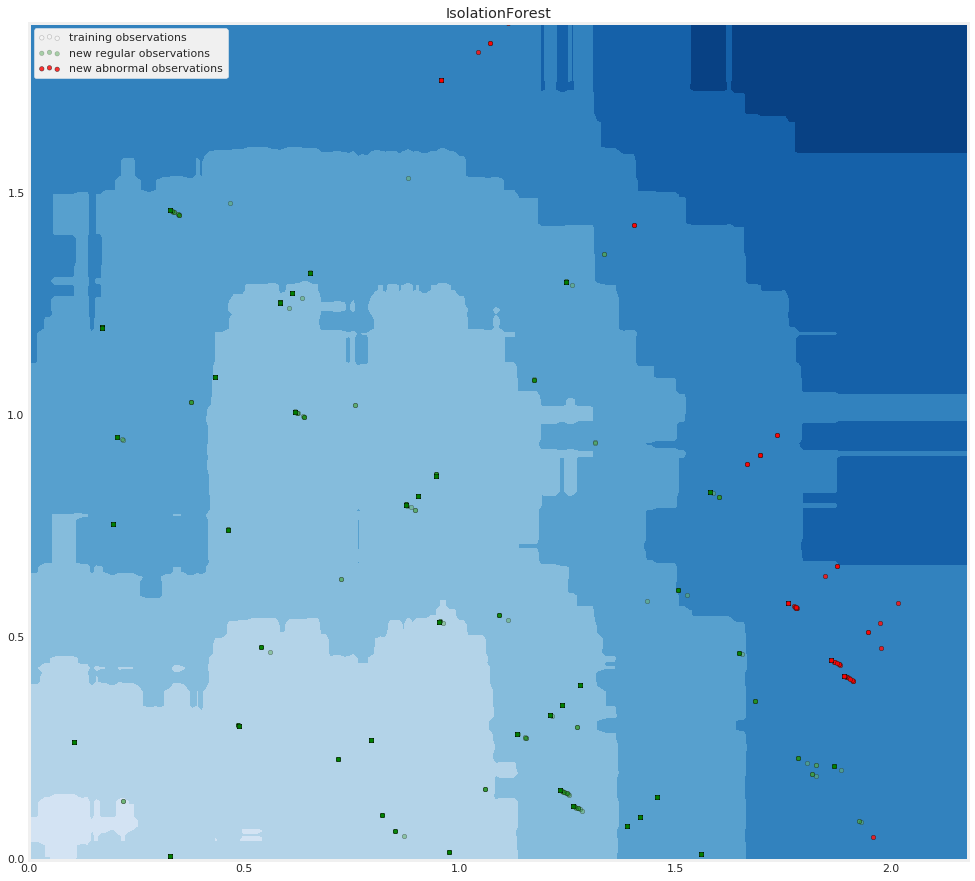

In [14]:
_ = plt.figure(figsize=(15, 15))
plt.title("IsolationForest")

plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white', s=20, edgecolor='k', alpha=0.3)
b2 = plt.scatter(inliers[:, 0], inliers[:, 1], c='green', s=20, edgecolor='k', alpha=0.3)
c = plt.scatter(outliers[:, 0], outliers[:, 1], c='red',  s=20, edgecolor='k', alpha=0.8)
plt.axis('tight')
plt.xlim((0, df2pca['d1'].max()))
plt.ylim((0, df2pca['d2'].max()))
plt.legend([b1, b2, c],
           ["training observations",
            "new regular observations", "new abnormal observations"],
           loc="upper left")
plt.show()

In [15]:
rng = np.random.RandomState(42)

# Generate train data
X_train = df3pca.as_matrix()
X_test = df3pca.sample(n=1000).as_matrix()
X_outliers = df3pca.sample(n=100).as_matrix()

# fit the model
clf = IsolationForest(n_estimators=50, max_samples=50, random_state=rng, n_jobs=48, contamination=0.07)
clf.fit(X_train)

y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)



df = pd.DataFrame(X_train, index=df3pca.index)

df['outlier'] = y_pred_train
df.columns = ['d1', 'd2', 'd3','outlier']


inliers = df.loc[df['outlier'] == 1].drop(columns='outlier').as_matrix()
outliers = df.loc[df['outlier'] == -1].drop(columns='outlier').as_matrix()

In [16]:
df.shape

(28986, 4)

In [17]:
df.head()

,d1,d2,d3,outlier
id,,,,
9d2ddfd1-d138-4f49-add9-35e8ad03ae36,-1.003296,0.277296,0.016785,1
a2ecc818-8e4f-44f9-bccb-4fd11dde6139,0.653964,1.319756,-0.469890,1
44b22e25-3263-4559-801a-faa7c2d646c5,-0.589105,0.333936,-0.282459,1
cb2b3ef2-f7d5-4b7e-969e-89aab7bfc8ea,0.327602,1.462492,0.666162,1
e71ac857-eaf2-42a7-8f12-47af4ea911f5,-0.589105,0.333936,-0.282459,1


In [18]:
#Print_Report(df)

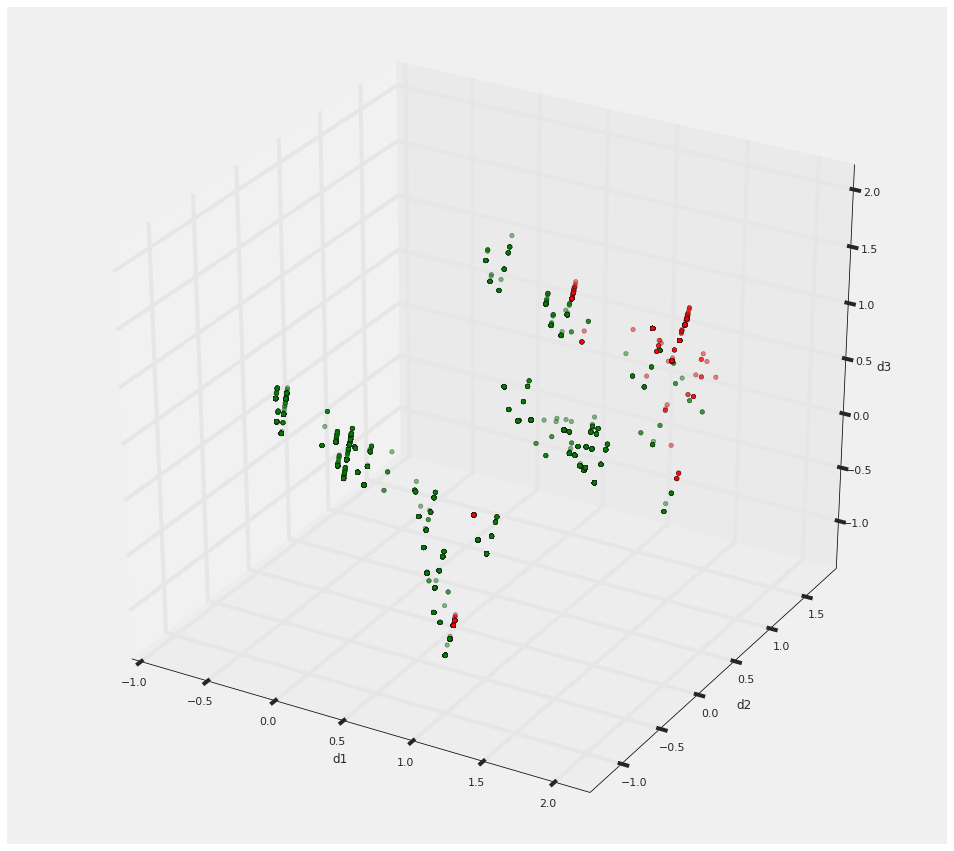

In [19]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(15, 15))


ax = fig.add_subplot(111, projection='3d')

ax.scatter(inliers[:, 0], inliers[:, 1], inliers[:, 2], c='green', edgecolor='k', alpha=0.5)
ax.scatter(outliers[:, 0], outliers[:, 1], outliers[:, 2], c='red',  s=20, edgecolor='k', alpha=0.5)



ax.set_xlabel('d1')
ax.set_ylabel('d2')
ax.set_zlabel('d3')

plt.xlim((df3pca['d1'].min(), df3pca['d1'].max()))
plt.ylim((df3pca['d2'].min(), df3pca['d2'].max()))
ax.set_zlim(df3pca['d3'].min(), df3pca['d3'].max())
plt.show()

In [20]:
import plotly.plotly as py
import plotly.graph_objs as go

import numpy as np
x, y, z = inliers[:, 0], inliers[:, 1], inliers[:, 2]

trace1 = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    name='Inliers',
    mode='markers',
    marker=dict(
        color='green',
        size=1.5,
        symbol='circle',
        line=dict(
            color='green',
            width=0.1
        ),
        opacity=0.7
    )
)

x2, y2, z2 = outliers[:, 0], outliers[:, 1], outliers[:, 2]
trace2 = go.Scatter3d(
    x=x2,
    y=y2,
    z=z2,
    name='Outliers',
    mode='markers',
    marker=dict(
        color='red',
        size=2,
        symbol='circle',
        line=dict(
            color='red',
            width=0.1
        ),
        opacity=0.9
    )
)
data = [trace1, trace2]
layout = go.Layout(
    title='Anomaly Detection for d1',
    width=1000,
    height=1000,
    scene = dict(
    xaxis=dict(
        title='d1',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    ),
    yaxis=dict(
        title='d2',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    ),
    zaxis=dict(
        title='d3',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    )),
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
    
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='BillinUsersOutliers')

In [21]:
sampledf3pca = df3pca.sample(n=700)
#sampledf3pca = df3pca.copy()

#db = DBSCAN(eps=0.3, min_samples=500, algorithm='kd_tree', n_jobs=-1).fit(sampledf3pca)
#db = SpectralClustering(n_clusters=3, eigen_solver='arpack', affinity="nearest_neighbors", n_jobs=-1).fit(sampledf3pca)
db = KMeans(n_clusters=3, n_jobs=96).fit(sampledf3pca)

labels = db.labels_
sampledf3pca['Cluster'] = pd.Series(labels, index=sampledf3pca.index)
Cluster0 = sampledf3pca.loc[sampledf3pca['Cluster'] == 0].drop(columns='Cluster').as_matrix()
Cluster1 = sampledf3pca.loc[sampledf3pca['Cluster'] == 1].drop(columns='Cluster').as_matrix()
Cluster2 = sampledf3pca.loc[sampledf3pca['Cluster'] == 2].drop(columns='Cluster').as_matrix()

In [22]:
#dball = KMeans(n_clusters=3, precompute_distances=True, n_jobs=-1).fit(df3pca)
#labels = dball.labels_
#df3pca['Cluster'] = pd.Series(labels, index=df3pca.index)

In [78]:
dball = load_object('./Cluster.pkl')
labels = dball.labels_
sampledf3pca = load_object('./sampledf3pca.pkl')
temp = load_object( './temp.pkl')
dforig = load_object( './df.pkl')
sampledf3pca['Cluster'] = pd.Series(labels, index=sampledf3pca.index)
Cluster0 = sampledf3pca.loc[sampledf3pca['Cluster'] == 0].drop(columns='Cluster').as_matrix()
Cluster1 = sampledf3pca.loc[sampledf3pca['Cluster'] == 1].drop(columns='Cluster').as_matrix()
Cluster2 = sampledf3pca.loc[sampledf3pca['Cluster'] == 2].drop(columns='Cluster').as_matrix()

In [93]:
dforig[['created_at','deleted_at', 'last_seen', 'updated_at']].tz = None

In [94]:
output = pd.concat([sampledf3pca, df.outlier, dforig, temp], axis=1)

In [103]:
writer = pd.ExcelWriter('./output.xlsx',
                        engine='xlsxwriter',
                        options={'remove_timezone': True})
output.to_excel(writer)

In [31]:
import plotly.plotly as py
import plotly.graph_objs as go

import numpy as np
x, y, z = Cluster0[:, 0], Cluster0[:, 1], Cluster0[:, 2]

trace1 = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    name='Cluster0',
    mode='markers',
    marker=dict(
        color='green',
        size=1.5,
        symbol='circle',
        line=dict(
            color='green',
            width=0.1
        ),
        opacity=0.9
    )
)

x2, y2, z2 = Cluster1[:, 0], Cluster1[:, 1], Cluster1[:, 2]
trace2 = go.Scatter3d(
    x=x2,
    y=y2,
    z=z2,
    name='Cluster1',
    mode='markers',
    marker=dict(
        color='red',
        size=2,
        symbol='circle',
        line=dict(
            color='red',
            width=0.1
        ),
        opacity=0.9
    )
)
x3, y3, z3 = Cluster2[:, 0], Cluster2[:, 1], Cluster2[:, 2]
trace3 = go.Scatter3d(
    x=x3,
    y=y3,
    z=z3,
    name='Cluster2',
    mode='markers',
    marker=dict(
        color='blue',
        size=2,
        symbol='circle',
        line=dict(
            color='blue',
            width=0.1
        ),
        opacity=0.9
    )
)
data = [trace1, trace2, trace3]
layout = go.Layout(
    title='\nClustering for Users',
    width=1000,
    height=1000,
    scene = dict(
    xaxis=dict(
        title='d1',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    ),
    yaxis=dict(
        title='d2',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    ),
    zaxis=dict(
        title='d3',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    )),
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
    
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='BillinUsersClusters')

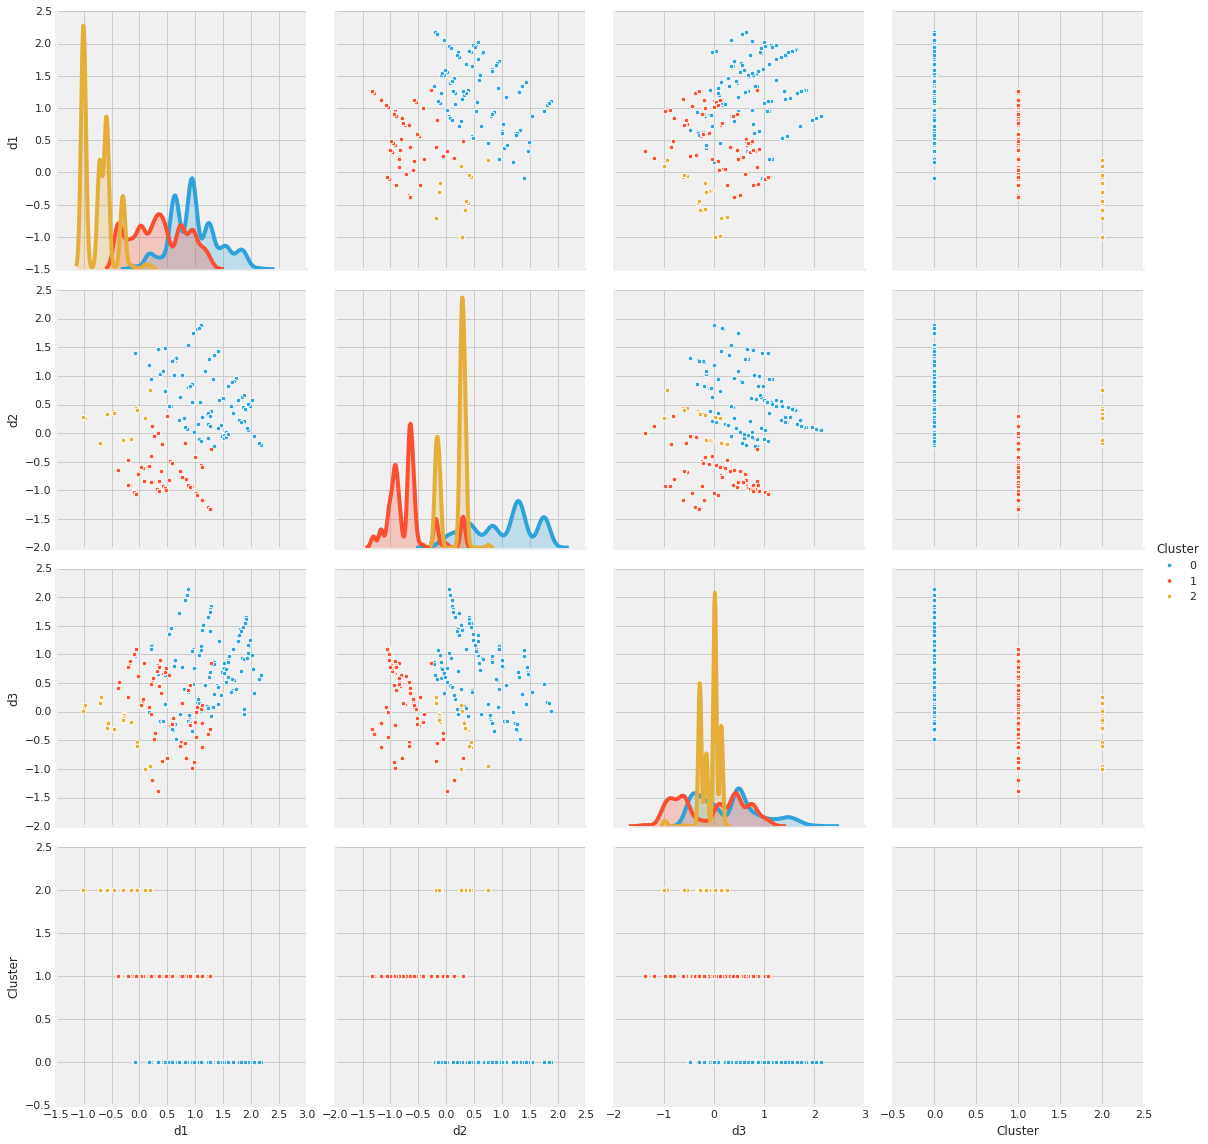

In [32]:
_ = sns.pairplot(sampledf3pca, size=4, hue='Cluster')

In [105]:
url='https://docs.google.com/spreadsheets/d/1TlAj8XZCoC57WQSVub45TLpuJpI2aSrgYJhIGTHRS-s/edit#gid=0'

In [106]:
dfMuno = pd.read_csv('https://docs.google.com/spreadsheets/d/' + 
                   '1TlAj8XZCoC57WQSVub45TLpuJpI2aSrgYJhIGTHRS-s' +
                   '/export?gid=0&format=csv',
                   # Set first column as rownames in data frame
                   index_col=1, header=1
                  )



In [108]:
dfMuno.head()

,Fecha Billin,Nombre,Apellidos,Teléfono,Comentarios Billin,Sector,COMENTARIOS MUNO,¿CONTRATA MUNO?,PRÓXIMA INTERACCIÓN
Email,,,,,,,,,
oliver.lopez@avanze.net,06-02,OLIVER,LOPEZ CORDOBA,653874707,llamar a partir del 14/02,Informático,"14/02 Llamada me pide que le llamemos mañana, ...",19/03/2018,NaN
jimba@hotmail.es,06-02,Jorge,Pablo Ramos Lozano,622687767,llamar mejor tardes,Marroquinería,08/02 Llamada 1: me comenta que está trabajand...,NaN,-
juanruizcristalero@gmail.com,06-02,JUAN MANUEL,NaN,653937802,llamar al mediodía,Cerrajería-Cristalería,"08/02 13:54 Llamada 1: está trabajando, me pid...",NaN,-
iluminacion.038electric@outlook.es,06-02,roberto,roberto de la rosa peñas,671733012,llamar al mediodía mejor,Electricidad,08/02 13:56 Llamada 1: está preparando un pres...,NaN,2019
jcmontesz@hotmail.com,07-02,JOSE CARLOS,JOSE CARLOS MONTES ZURITA,664318100,llamar mejor 14:00,Topográfo,08/02 14:00 Llamada 1: está hablando con un cl...,NaN,-


In [115]:
tmp = output.join(dfMuno, on='email')

In [119]:
tmp[~tmp.Nombre.isnull() ].shape

(83, 79)

In [122]:
writer = pd.ExcelWriter('./Muno.xlsx',
                        engine='xlsxwriter',
                        options={'remove_timezone': True})

tmp[~tmp.Nombre.isnull()].to_excel(writer)